In [1]:
# Load the dataset and some utility functions
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

import torch
import torch.utils.data as utils
import torch.nn.functional as F
import torch.optim as optim

import pyro
from pyro.distributions.torch import Normal, Uniform
from pyro.distributions.torch import Categorical
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import Predictive

pyro.clear_param_store()

# If GPU is available set it to a GPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the iris dataset
data = load_iris()
X = data['data']
Y = data['target']

X = scale(X, axis=0)
print(X,Y)
print(X.shape,Y.shape)

# Scale all data with 0 mean and unit standard deviation
for i in range(X.shape[1]):
    print(X[:,i].mean(),X[:,i].std())

[[-9.00681170e-01  1.01900435e+00 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00 -1.31979479e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.38535265e+00  3.28414053e-01 -1.39706395e+00 -1.31544430e+00]
 [-1.50652052e+00  9.82172869e-02 -1.28338910e+00 -1.31544430e+00]
 [-1.02184904e+00  1.24920112e+00 -1.34022653e+00 -1.31544430e+00]
 [-5.37177559e-01  1.93979142e+00 -1.16971425e+00 -1.05217993e+00]
 [-1.50652052e+00  7.88807586e-01 -1.34022653e+00 -1.18381211e+00]
 [-1.02184904e+00  7.88807586e-01 -1.28338910e+00 -1.31544430e+00]
 [-1.74885626e+00 -3.62176246e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00  9.82172869e-02 -1.28338910e+00 -1.44707648e+00]
 [-5.37177559e-01  1.47939788e+00 -1.28338910e+00 -1.31544430e+00]
 [-1.26418478e+00  7.88807586e-01 -1.22655167e+00 -1.31544430e+00]
 [-1.26418478e+00 -1.31979479e-01 -1.34022653e+00 -1.44707648e+00]
 [-1.87002413e+00 -1.31979479e-01 -1.51073881e+00 -1.44707648e+00]
 [-5.25060772e-02  2.16998818e+00 -1.45390138e+00 -1.31544430e

 [ 6.86617933e-02 -1.31979479e-01  7.62758269e-01  7.90670654e-01]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
(150, 4) (150,)
-1.4684549872375404e-15 1.0
-1.8237263551175904e-15 1.0000000000000004
-1.6105635343895603e-15 0.9999999999999999
-9.473903143468002e-16 1.0


In [3]:
# Split the dataset into training, test, validation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(96, 4) (24, 4) (30, 4)
(96,) (24,) (30,)


In [4]:
# Create loaders for trainining, test, validation, set the batch size to 8
def create_loader(x,y,batch_size = 8):
    tensor_x = torch.stack([torch.Tensor(i) for i in x]) 
    tensor_y = torch.stack([torch.tensor(np.array(i), dtype=torch.long) for i in y])
    dataset = utils.TensorDataset(tensor_x,tensor_y)
    return dataset, utils.DataLoader(dataset,batch_size = batch_size) 

train_dataset, train_loader = create_loader(X_train,y_train)
val_dataset, val_loader = create_loader(X_val,y_val)
test_dataset, test_loader = create_loader(X_test,y_test)

In [5]:
# Define a very simple model consisting of 4 inputs, 10 input nodes and 4 output nodes
class FCNet(PyroModule):
    def __init__(self):
        super(FCNet, self).__init__()
        self.input = PyroModule[torch.nn.Linear](4, 10)
        self.input.weight = PyroSample(Normal(0., 1.).expand([10, 4]).to_event(1))
        self.input.bias = PyroSample(Normal(0., 10.).expand([10]).to_event(1))
        
        self.output = PyroModule[torch.nn.Linear](10, 4)
        self.output.weight = PyroSample(Normal(0., 1.).expand([4, 10]).to_event(1))
        self.output.bias = PyroSample(Normal(0., 10.).expand([4]).to_event(1))
        
    def forward(self, x, y=None):
        y_hat = F.relu(self.input(x))
        l_hat = F.log_softmax(self.output(y_hat))
        with pyro.plate("data", x.shape[0]):
            pyro.sample("obs", Categorical(logits=l_hat), obs=y)
        return l_hat
    
model = FCNet()
model.to(DEVICE)
guide = AutoDiagonalNormal(model)

In [6]:
# Define an optimiser in this case ADAM and we are going to use the double stochastic VI and maximise the ELBO
optim = pyro.optim.Adam({"lr": 0.01})
svi = pyro.infer.svi.SVI(model, guide, optim, loss=pyro.infer.trace_elbo.Trace_ELBO())

In [7]:
# Since Bayesian NN functions thanks to sampling the models
# we need to sample the model several times to get several different estimates
# for the input data x 
num_samples = 10
predictive = Predictive(model, guide=guide, num_samples=10,
                        return_sites=("obs", "_RETURN"))
def predict(x):
    yhats = predictive(x)["obs"]
    mean = torch.mean(yhats.float(), 0)
    mean = mean.round().numpy()
    std = torch.std(yhats.float(), 0).numpy()
    return mean, std

In [8]:
# Just a utility function to calculate the accuracy
def accuracy(out, labels):
    return np.sum(out==labels)/float(labels.size)

In [9]:
EPOCHS = 5

train_loss = []
val_loss = []

train_acc = []
val_acc = []

train_std = []
val_std = []

loss = svi.step(train_dataset.tensors[0].to(DEVICE)[0],train_dataset.tensors[1].to(DEVICE)[0])

with torch.no_grad():
    t,t_std = predict(train_dataset.tensors[0].float())
    v,v_std = predict(val_dataset.tensors[0].float())
    t_loss = svi.evaluate_loss(train_dataset.tensors[0].to(DEVICE), train_dataset.tensors[1].to(DEVICE))
    v_loss = svi.evaluate_loss(val_dataset.tensors[0].to(DEVICE), val_dataset.tensors[1].to(DEVICE))
    train_loss.append(t_loss)
    val_loss.append(v_loss)
    train_acc.append(accuracy(t,train_dataset.tensors[1].numpy()))
    val_acc.append(accuracy(v,val_dataset.tensors[1].numpy()))
    train_std.append(np.mean(t_std))
    val_std.append(np.mean(v_std))
    print("Training accuracy: {0:.2f}".format(train_acc[-1]))
    print("Validation accuracy: {0:.2f}".format(val_acc[-1]))

    # The main training loop
    
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        loss = svi.step(inputs, labels)
        break

        running_loss += loss
        if i % 2 == 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2))
            running_loss = 0.0
    
           
    with torch.no_grad():
        t,t_std = predict(train_dataset.tensors[0].to(DEVICE))
        v,v_std = predict(val_dataset.tensors[0].to(DEVICE))
        t_loss = svi.evaluate_loss(train_dataset.tensors[0].to(DEVICE), train_dataset.tensors[1].to(DEVICE))
        v_loss = svi.evaluate_loss(val_dataset.tensors[0].to(DEVICE), val_dataset.tensors[1].to(DEVICE))
        train_loss.append(t_loss)
        val_loss.append(v_loss)
        train_acc.append(accuracy(t,train_dataset.tensors[1].numpy()))
        val_acc.append(accuracy(v,val_dataset.tensors[1].numpy()))
        train_std.append(t_std.mean())
        val_std.append(v_std.mean())
        print("Training accuracy: {0:.2f}".format(train_acc[-1]))
        print("Validation accuracy: {0:.2f}".format(val_acc[-1]))
   
print('Finished Training')
with torch.no_grad():
    t,t_std = predict(test_dataset.tensors[0])
    print("Test accuracy: {0:.2f}".format(accuracy(t,test_dataset.tensors[1].numpy()))) 

C:\Users\uceemfe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Training accuracy: 0.33
Validation accuracy: 0.38
Training accuracy: 0.33
Validation accuracy: 0.33
Training accuracy: 0.32
Validation accuracy: 0.33
Training accuracy: 0.36
Validation accuracy: 0.33
Training accuracy: 0.31
Validation accuracy: 0.33
Training accuracy: 0.38
Validation accuracy: 0.42
Finished Training
Test accuracy: 0.27


[1.1503876, 1.1219848, 1.1288507, 1.183417, 1.1195178, 1.1551424] [1.1856873, 1.0041591, 1.1708155, 1.1748213, 1.1396784, 1.0762515]


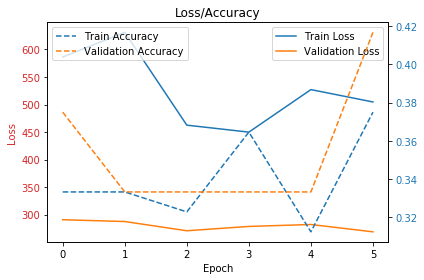

In [10]:
# Plot the loss, accuracy as well as the standard deviation
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel("Epoch")
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_loss,label="Train Loss")
ax1.plot(val_loss,label="Validation Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(train_acc,linestyle='dashed',label="Train Accuracy")
ax2.plot(val_acc,linestyle='dashed',label="Validation Accuracy")
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend()

plt.title("Loss/Accuracy")
fig.tight_layout()

print(train_std,val_std)